# YelpChi

In [1]:
import pandas as pd
import numpy as np
from tqdm._tqdm_notebook import tqdm_notebook
tqdm_notebook.pandas()
from textblob import TextBlob
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn import metrics
from sklearn.metrics import classification_report
import string
from matplotlib import pyplot
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import wordnet
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from sklearn.metrics import classification_report
en_stop = set(nltk.corpus.stopwords.words('english'))
import gensim
from gensim import corpora
import random
import pyLDAvis.gensim
from gensim.models.callbacks import PerplexityMetric
from sklearn.feature_extraction.text import TfidfVectorizer
from keras.models import Sequential
import pickle
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential, Model
from keras.layers import Dense, Flatten, LSTM, Conv1D, MaxPooling1D, Dropout, Activation, TimeDistributed, Bidirectional
from keras.layers.embeddings import Embedding
from keras import optimizers
from keras.layers import Input
from keras.callbacks import EarlyStopping

D:\Anaconda3\lib\site-packages\gensim\utils.py:1212: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")
Using TensorFlow backend.
D:\Anaconda3\lib\site-packages\tensorflow\python\framework\ops.py:923: DeprecationWarning: builtin type EagerTensor has no __module__ attribute
  EagerTensor = c_api.TFE_Py_InitEagerTensor(_EagerTensorBase)
D:\Anaconda3\lib\site-packages\tensorflow\python\util\tf_inspect.py:75: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  return _inspect.getargspec(target)
D:\Anaconda3\lib\site-packages\tensorflow\python\util\tf_inspect.py:75: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  return _inspect.getargspec(target)
D:\Anaconda3\lib\site-packages\tensorflow\python\util\tf_inspect.py:75: DeprecationWarning: inspect.getargspec() is deprecated, use inspec

In [27]:
meta = pd.read_csv(r"E:\Yelp\YelpNYC\metadata", sep="\\t", header=None)
data = pd.read_csv(r"E:\Yelp\YelpNYC\reviewContent", sep="\\t", header=None)

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """Entry point for launching an IPython kernel.
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  


In [28]:
print(meta.head())
print(data.head())
print(meta.shape, data.shape)

     0  1    2  3           4
0  923  0  3.0 -1  2014-12-08
1  924  0  3.0 -1  2013-05-16
2  925  0  4.0 -1  2013-07-01
3  926  0  4.0 -1  2011-07-28
4  927  0  4.0 -1  2010-11-01
     0  1           2                                                  3
0  923  0  2014-12-08  The food at snack is a selection of popular Gr...
1  924  0  2013-05-16  This little place in Soho is wonderful. I had ...
2  925  0  2013-07-01  ordered lunch for 15 from Snack last Friday. Â...
3  926  0  2011-07-28  This is a beautiful quaint little restaurant o...
4  927  0  2010-11-01  Snack is great place for a Â casual sit down l...
(359052, 5) (359052, 4)


In [29]:
data1 = pd.DataFrame()
data1[0] = data[3]
data1[1] = meta[3]
data1[2] = meta[2]
data = data1

In [30]:
print(data.head(),"\n", data.shape)

                                                   0  1    2
0  The food at snack is a selection of popular Gr... -1  3.0
1  This little place in Soho is wonderful. I had ... -1  3.0
2  ordered lunch for 15 from Snack last Friday. Â... -1  4.0
3  This is a beautiful quaint little restaurant o... -1  4.0
4  Snack is great place for a Â casual sit down l... -1  4.0 
 (359052, 3)


In [31]:
def binarize(charac):
    if charac==-1:
        return 1
    else:
        return 0

data[1] = data[1].apply(lambda c: binarize(c))
data[2] = data[2].apply(lambda x: int(x))
data.head()

,0,1,2
0,The food at snack is a selection of popular Gr...,1,3
1,This little place in Soho is wonderful. I had ...,1,3
2,ordered lunch for 15 from Snack last Friday. Â...,1,4
3,This is a beautiful quaint little restaurant o...,1,4
4,Snack is great place for a Â casual sit down l...,1,4


In [32]:
print("0: Real, 1: Fake\n\n", data[1].value_counts())

0: Real, 1: Fake

 0    322167
1     36885
Name: 1, dtype: int64


In [33]:
#Word Count
data['word_count'] = data[0].progress_apply(lambda st: len(str(st).split()))
data.head()

,0,1,2,word_count
0,The food at snack is a selection of popular Gr...,1,3,40
1,This little place in Soho is wonderful. I had ...,1,3,52
2,ordered lunch for 15 from Snack last Friday. Â...,1,4,34
3,This is a beautiful quaint little restaurant o...,1,4,92
4,Snack is great place for a Â casual sit down l...,1,4,107


In [35]:
#Sentimental Deviation
pos_words = pd.read_table(r"C:\Users\elonm\Desktop\Yelp-Dataset-Analysis-master\poswords.txt", header=None)
neg_words = pd.read_table(r"C:\Users\elonm\Desktop\Yelp-Dataset-Analysis-master\negwords.txt", header=None)

def sentimental_deviation(txt):
    dev = 0
    flag = 0
    for word in txt.split():
        for pos in pos_words[0]:
            if pos == word.lower():
                if flag == -1:
                    dev = dev+1
                flag = 1
                #print(word, dev, flag)
        for neg in neg_words[0]:
            if neg == word.lower():
                if flag == 1:
                    dev = dev+1
                flag = -1
                #print(word, dev, flag)
    return dev

data['deviation'] = data[0].progress_apply(lambda txt: sentimental_deviation(str((txt))))
data.head()

,0,1,2,word_count,deviation
0,The food at snack is a selection of popular Gr...,1,3,40,1
1,This little place in Soho is wonderful. I had ...,1,3,52,0
2,ordered lunch for 15 from Snack last Friday. Â...,1,4,34,0
3,This is a beautiful quaint little restaurant o...,1,4,92,0
4,Snack is great place for a Â casual sit down l...,1,4,107,2


In [36]:
data.to_csv(r"E:\Yelp\YelpNYC\data.csv")

In [37]:
#Sentiment Polarity
data['polarity'] = data[0].progress_apply(lambda txt: TextBlob(str(txt)).sentiment.polarity)
data.head()

,0,1,2,word_count,deviation,polarity
0,The food at snack is a selection of popular Gr...,1,3,40,1,0.195833
1,This little place in Soho is wonderful. I had ...,1,3,52,0,0.025000
2,ordered lunch for 15 from Snack last Friday. Â...,1,4,34,0,0.220000
3,This is a beautiful quaint little restaurant o...,1,4,92,0,0.555134
4,Snack is great place for a Â casual sit down l...,1,4,107,2,0.138715


In [38]:
#Positive Negative word count
def count_sentiment_pos(sentence):
    count = 0
    for word in sentence.split():
        for sent_word in pos_words[0]:
            if sent_word in word:
                count += 1
    return count

def count_sentiment_neg(sentence):
    count = 0
    for word in sentence.split():
        for sent_word in neg_words[0]:
            if sent_word in word:
                count += 1
    return count

data['pos_word_count'] = data[0].progress_apply(lambda txt: count_sentiment_pos(str(txt)))
data['neg_word_count'] = data[0].progress_apply(lambda txt: count_sentiment_neg(str(txt)))
data.head()

,0,1,2,word_count,deviation,polarity,pos_word_count,neg_word_count
0,The food at snack is a selection of popular Gr...,1,3,40,1,0.195833,2,1
1,This little place in Soho is wonderful. I had ...,1,3,52,0,0.025000,6,4
2,ordered lunch for 15 from Snack last Friday. Â...,1,4,34,0,0.220000,4,3
3,This is a beautiful quaint little restaurant o...,1,4,92,0,0.555134,11,6
4,Snack is great place for a Â casual sit down l...,1,4,107,2,0.138715,13,8


In [39]:
data['count_sentiment'] = data['pos_word_count'] + data['neg_word_count']
data.head()

,0,1,2,word_count,deviation,polarity,pos_word_count,neg_word_count,count_sentiment
0,The food at snack is a selection of popular Gr...,1,3,40,1,0.195833,2,1,3
1,This little place in Soho is wonderful. I had ...,1,3,52,0,0.025000,6,4,10
2,ordered lunch for 15 from Snack last Friday. Â...,1,4,34,0,0.220000,4,3,7
3,This is a beautiful quaint little restaurant o...,1,4,92,0,0.555134,11,6,17
4,Snack is great place for a Â casual sit down l...,1,4,107,2,0.138715,13,8,21


In [40]:
#Making a checkpoint
data.to_csv(r"E:\Yelp\YelpChi\data.csv")

In [41]:
data.head()

,0,1,2,word_count,deviation,polarity,pos_word_count,neg_word_count,count_sentiment
0,The food at snack is a selection of popular Gr...,1,3,40,1,0.195833,2,1,3
1,This little place in Soho is wonderful. I had ...,1,3,52,0,0.025000,6,4,10
2,ordered lunch for 15 from Snack last Friday. Â...,1,4,34,0,0.220000,4,3,7
3,This is a beautiful quaint little restaurant o...,1,4,92,0,0.555134,11,6,17
4,Snack is great place for a Â casual sit down l...,1,4,107,2,0.138715,13,8,21


In [42]:
def clean_text(text):
    trans = str.maketrans('', '', string.punctuation)
    words = text.split()
    stripped = [word.translate(trans) for word in words]
    a = [x for x in stripped if x!=""]
    b = [word.lower() for word in a]
    b = ' '.join(b)
    return b

data[0] = data[0].progress_apply(lambda text: clean_text(text))
data.head()

,0,1,2,word_count,deviation,polarity,pos_word_count,neg_word_count,count_sentiment
0,the food at snack is a selection of popular gr...,1,3,40,1,0.195833,2,1,3
1,this little place in soho is wonderful i had a...,1,3,52,0,0.025000,6,4,10
2,ordered lunch for 15 from snack last friday â ...,1,4,34,0,0.220000,4,3,7
3,this is a beautiful quaint little restaurant o...,1,4,92,0,0.555134,11,6,17
4,snack is great place for a â casual sit down l...,1,4,107,2,0.138715,13,8,21


In [43]:
#Stemming/Lemmatization
lemmatizer = WordNetLemmatizer()
#print(lemmatizer.lemmatize("going"))

def nltk2wn_tag(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return None

def lemmatize_sentence(sentence):
    nltk_tagged = nltk.pos_tag(nltk.word_tokenize(sentence))  
    wn_tagged = map(lambda x: (x[0], nltk2wn_tag(x[1])), nltk_tagged)

    res_words = []
    for word, tag in wn_tagged:
        if tag is None:            
            res_words.append(word)
        else:
            res_words.append(lemmatizer.lemmatize(word, tag))
    return " ".join(res_words)

# test =  "You better lose yourself in the music, the moment You own it, you better never let it go You only get one shot, do not miss your chance to blow This opportunity comes once in a lifetime"
# print(lemmatize_sentence(test))

data[0] = data[0].progress_apply(lambda text: lemmatize_sentence(text))

In [45]:
data.to_csv(r"E:\Yelp\YelpNYC\data.csv")
data.head()

,0,1,2,word_count,deviation,polarity,pos_word_count,neg_word_count,count_sentiment
0,the food at snack be a selection of popular gr...,1,3,40,1,0.195833,2,1,3
1,this little place in soho be wonderful i have ...,1,3,52,0,0.025000,6,4,10
2,order lunch for 15 from snack last friday â on...,1,4,34,0,0.220000,4,3,7
3,this be a beautiful quaint little restaurant o...,1,4,92,0,0.555134,11,6,17
4,snack be great place for a â casual sit down l...,1,4,107,2,0.138715,13,8,21


In [46]:
#Creating a train test split for the final processing
X_train, X_test, y_train, y_test = train_test_split(data[[0, 2, 'word_count', 'deviation', 'polarity', 'count_sentiment', 'pos_word_count', 'neg_word_count']], data[1], test_size=0.25, random_state=42)
X_train.to_csv(r"E:\Yelp\YelpNYC\X_train")
X_test.to_csv(r"E:\Yelp\YelpNYC\X_test")
y_train.to_csv(r"E:\Yelp\YelpNYC\y_train")
y_test.to_csv(r"E:\Yelp\YelpNYC\y_test")
print(X_train.shape, X_test.shape)
print(y_test.value_counts(), y_train.value_counts())

(269289, 8) (89763, 8)
0    80456
1     9307
Name: 1, dtype: int64 0    241711
1     27578
Name: 1, dtype: int64


# Model based on features

In [47]:
X_train = X_train[[2, 'word_count', 'deviation', 'polarity', 'count_sentiment', 'pos_word_count', 'neg_word_count']]
X_test = X_test[[2, 'word_count', 'deviation', 'polarity', 'count_sentiment', 'pos_word_count', 'neg_word_count']]

In [48]:
#SVM
svm_clf = svm.SVC(kernel='sigmoid', gamma='auto', verbose=True)
svm_clf.fit(X_train, y_train)  

[LibSVM]

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='sigmoid',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=True)

In [49]:
y_pred = svm_clf.predict(X_test)
print(classification_report(y_test, y_pred))

C:\Users\elonm\AppData\Roaming\Python\Python36\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

           0       0.90      1.00      0.95     80456
           1       0.00      0.00      0.00      9307

   micro avg       0.90      0.90      0.90     89763
   macro avg       0.45      0.50      0.47     89763
weighted avg       0.80      0.90      0.85     89763



In [50]:
#XGB
xgb_model = XGBClassifier(learning_rate = 0.2, objective= 'binary:logistic')
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.2, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [51]:
y_pred = xgb_model.predict(X_test)
y_pred = [round(value) for value in y_pred]
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.90      1.00      0.95     80456
           1       1.00      0.00      0.00      9307

   micro avg       0.90      0.90      0.90     89763
   macro avg       0.95      0.50      0.47     89763
weighted avg       0.91      0.90      0.85     89763



[0.15601783 0.2154532  0.06835067 0.25854382 0.10698365 0.09658246
 0.09806835]


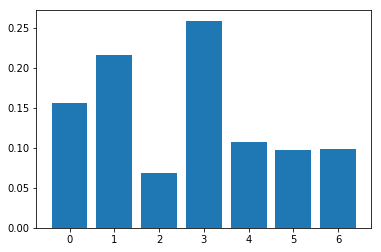

In [52]:
print(xgb_model.feature_importances_)
# plot
pyplot.bar(range(len(xgb_model.feature_importances_)), xgb_model.feature_importances_)
pyplot.show()

In [53]:
y_pred = pd.DataFrame(y_pred)
y_pred.to_csv(r"E:\Yelp\YelpNYC\res_features.csv", header=None)

# Model based on LDA

In [54]:
X_train = pd.read_csv(r"E:\Yelp\YelpNYC\X_train")
X_test = pd.read_csv(r"E:\Yelp\YelpNYC\X_test")
y_train = pd.read_csv(r"E:\Yelp\YelpNYC\y_train", header=None)
y_test = pd.read_csv(r"E:\Yelp\YelpNYC\y_test", header=None)
print(X_train.shape, y_test.shape, y_train.shape)

(269289, 9) (89763, 2) (269289, 2)


In [55]:
X_train = X_train['0']
X_test = X_test['0']
y_train = y_train[1]
y_test = y_test[1]

In [56]:
data = pd.read_csv(r"E:\Yelp\YelpNYC\data.csv")
data.columns

Index(['Unnamed: 0', '0', '1', '2', 'word_count', 'deviation', 'polarity',
       'pos_word_count', 'neg_word_count', 'count_sentiment'],
      dtype='object')

In [57]:
def preprocess_text(text):
    #Getting tokens from text
    tokens = []
    text_split = text.split()
    for token in text_split:
        tokens.append(token)
    #Removing stop words from the list of tokens
    tokens = [token for token in tokens if token not in en_stop]
    return tokens

real = data[data['1'] == 0]
fake = data[data['1'] == 1]
print("Real:",real.shape,"Fake:",fake.shape)

Real: (322167, 10) Fake: (36885, 10)


In [58]:
#Converting all our text to a list of preprocessed tokens
review_data = []
pbar = tqdm_notebook(total=data.shape[0])
for text in data['1']:
    tokens = preprocess_text(str(text))
    review_data.append(tokens)
    pbar.update(1)
pbar.close()

In [59]:
#Separating real and fake reviews in different lists
real = []
fake = []

for i in range(len(review_data)):
    if data['1'][i] == 0:
        real.append(review_data[i])
    else:
        fake.append(review_data[i])

print(len(real), len(fake))

322167 36885


In [60]:
rangex = X_train.shape[0]
print(rangex)

269289


In [61]:
real_indexes = []
fake_indexes = []
real_train = []
fake_train = []

for i in range(rangex):
    if y_train[i] == 0:
        real_train.append(X_train[i])
    else:
        fake_train.append(X_train[i])

In [62]:
real_t = []
fake_t = []
pbar = tqdm_notebook(total=data.shape[0])
for text in real_train:
    tokens = preprocess_text(str(text))
    real_t.append(tokens)
    pbar.update(1)
pbar.close()
real_train = real_t

pbar = tqdm_notebook(total=data.shape[0])
for text in fake_train:
    tokens = preprocess_text(str(text))
    fake_t.append(tokens)
    pbar.update(1)
pbar.close()
fake_train = fake_t

In [63]:
print("Sample of token:",real_train[2], "||",fake_train[21])

Sample of token: ['consistently', 'superior', 'food', 'awful', 'sound', 'level', 'pass', 'dessert', 'noise', 'bad', 'tell', 'loud', 'music', 'enhance', 'food'] || ['amaze', 'taste', 'presentation', 'great', 'spot', 'take', 'friend', 'town', 'anyone', 'want', 'impress', 'spaghetti', 'dish', 'definitely', 'one', 'best', 'ive', 'ever', 'taste', 'even', 'include', 'spaghetti', 'italy', 'come', 'birthday', 'group', '4', 'girl', 'seat', 'promptly', 'serve', 'amazing', 'cocktail', 'mine', 'good', 'remember', 'tiny', 'strawberry', 'along', 'champagne', 'waitress', 'sweet', 'overhear', 'us', 'talk', 'birthday', 'us', 'complimentary', 'dessert', 'platter', 'say', 'happy', 'birthday', 'go', 'regret']


In [64]:
review_data = []
for i in real_train:
    review_data.append(i)
for i in fake_train:
    review_data.append(i)
#Creating dictionary of our data using Gensim and saving 
dictionary = corpora.Dictionary(review_data)
dictionary.save('dictionary.gensim')

#For saving corpus, use:
#pickle.dump(corpus, open('corpus.pkl', 'wb'))

In [65]:
NUM_TOPICS = 5

#Getting 5 topics from real_train
real_corpus = [dictionary.doc2bow(text) for text in real_train]
perplexity1 = PerplexityMetric(corpus=real_corpus)
real_model = gensim.models.ldamodel.LdaModel(real_corpus, num_topics = NUM_TOPICS, id2word=dictionary, passes=20, eval_every=1000)
real_topics = real_model.print_topics(num_words=7)
for topic in real_topics:
    print(topic)

#Getting 5 topics from fake_train
fake_corpus = [dictionary.doc2bow(text) for text in fake_train]
perplexity2 = PerplexityMetric(corpus=fake_corpus)
fake_model = gensim.models.ldamodel.LdaModel(fake_corpus, num_topics = NUM_TOPICS, id2word=dictionary, passes=20, eval_every=1000)
fake_topics = fake_model.print_topics(num_words=7)
for topic in fake_topics:
    print(topic)

(0, '0.021*"pork" + 0.015*"good" + 0.012*"ramen" + 0.011*"rice" + 0.011*"noodle" + 0.010*"place" + 0.010*"get"')
(1, '0.029*"food" + 0.028*"great" + 0.027*"place" + 0.020*"good" + 0.013*"service" + 0.013*"go" + 0.010*"love"')
(2, '0.191*"â" + 0.012*"dish" + 0.009*"restaurant" + 0.007*"wine" + 0.007*"dessert" + 0.006*"pasta" + 0.006*"menu"')
(3, '0.015*"get" + 0.012*"go" + 0.011*"wait" + 0.011*"place" + 0.010*"food" + 0.010*"time" + 0.009*"order"')
(4, '0.014*"good" + 0.012*"cheese" + 0.011*"fry" + 0.011*"chicken" + 0.010*"sauce" + 0.010*"get" + 0.009*"like"')
(0, '0.003*"e" + 0.003*"de" + 0.002*"hood" + 0.002*"la" + 0.002*"que" + 0.001*"un" + 0.001*"die"')
(1, '0.056*"pizza" + 0.012*"ramen" + 0.010*"dumpling" + 0.010*"noodle" + 0.009*"slice" + 0.008*"pie" + 0.007*"crust"')
(2, '0.029*"â" + 0.011*"get" + 0.010*"food" + 0.010*"go" + 0.009*"order" + 0.008*"wait" + 0.008*"us"')
(3, '0.035*"â" + 0.020*"food" + 0.019*"great" + 0.019*"place" + 0.016*"good" + 0.011*"go" + 0.010*"love"')
(4, '0

In [66]:
lda_display = pyLDAvis.gensim.prepare(real_model, real_corpus, dictionary, sort_topics=False)
pyLDAvis.display(lda_display)

D:\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


In [67]:
lda_display = pyLDAvis.gensim.prepare(fake_model, fake_corpus, dictionary, sort_topics=False)
pyLDAvis.display(lda_display)

D:\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


In [68]:
test_set = []
pbar = tqdm_notebook(total=X_test.shape[0])
for text in X_test:
    tokens = preprocess_text(str(text))
    test_set.append(tokens)
    pbar.update(1)
pbar.close()
X_test = test_set

In [69]:
dictionary.doc2bow(X_test[0])

[(58, 1)]

In [70]:
#Making predictions based on topics
y_pred = []

for test_text in X_test:
    test_doc_bow = dictionary.doc2bow(test_text)
    real_scores = []
    fake_scores = []
    for i in real_model.get_document_topics(test_doc_bow):
        #real_model.get_document_topics(new_doc_bow)[0][1] -> Fit value of doc on topic 0
        real_scores.append(i[1])
    for i in fake_model.get_document_topics(test_doc_bow):
        fake_scores.append(i[1])
        
    #Best Fit on real model
    real_fit = max(real_scores)
    #Best Fit on fake model
    fake_fit = max(fake_scores)
    
    if real_fit >= fake_fit:
        y_pred.append(0)
    else:
        y_pred.append(1)    

In [71]:
#Evaluating
real_correct = 0
fake_correct = 0

for i in range(len(y_test)):
    if y_pred[i] == y_test[i]:
        if y_test[i] == 0:
            real_correct = real_correct + 1
        else:
            fake_correct = fake_correct + 1
        
acc = ((real_correct+fake_correct)/len(y_test))*100
print("Overall Accuracy:", acc,"%")
print("Real correct:", real_correct)
print("Fake correct:", fake_correct)

Overall Accuracy: 28.068357786615866 %
Real correct: 17772
Fake correct: 7423


In [72]:
y_pred = pd.DataFrame(y_pred)
y_pred.to_csv(r"E:\Yelp\YelpNYC\res_lda.csv", header=None)

# Neural Network Model

In [78]:
X_train = pd.read_csv(r"E:\Yelp\YelpNYC\X_train")
X_test = pd.read_csv(r"E:\Yelp\YelpNYC\X_test")
y_train = pd.read_csv(r"E:\Yelp\YelpNYC\y_train", header=None)
y_test = pd.read_csv(r"E:\Yelp\YelpNYC\y_test", header=None)
print(X_train.shape, y_test.shape, y_train.shape)

(269289, 9) (89763, 2) (269289, 2)


In [85]:
X_train['0'].astype(str)

0         ive never be here and not like my food hand do...
1         this place be great murat be the man ive love ...
2         consistently superior food and awful sound lev...
3         the place be unassuming but the food be great ...
4         i may be the only reviewer whose interest in p...
5         save your time and money youre much good off a...
6         one of the most overrated place that make me s...
7         i get to the restaurant around 7pm on a friday...
8         food be so so but the people be so mean really...
9         great experience friendly and knowledgeable se...
10        my second time here totally mediocre the kale ...
11        i have be eat here since it open the food have...
12        wow well worth the wait let me start off by sa...
13        stick out like a sore thumb in a not quite yet...
14        best french onion soup ever i mean ever get it...
15        be here twice and i fing love it everything iv...
16        now how many place in new york

In [86]:
tokenizer = Tokenizer(num_words= 2000)
tokenizer.fit_on_texts(str(X_train['0']))
sequences = tokenizer.texts_to_sequences(X_train['0'].astype(str))
data1 = pad_sequences(sequences, maxlen=100)

In [87]:
model = Sequential()
model.add(Embedding(2000, 32, input_length=100))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 100, 32)           64000     
_________________________________________________________________
flatten_2 (Flatten)          (None, 3200)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 256)               819456    
_________________________________________________________________
dense_6 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_7 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 65        
Total params: 924,673
Trainable params: 924,673
Non-trainable params: 0
_________________________________________________________________


In [88]:
model.fit(data1, y_train[1], batch_size=1000, epochs=3, verbose = 1)

Epoch 1/3


214000/269289 [======================>.......] - ETA: 2:21 - loss: 0.6795 - acc: 0.906 - ETA: 1:19 - loss: 0.5057 - acc: 0.909 - ETA: 59s - loss: 0.4969 - acc: 0.905 - ETA: 49s - loss: 0.4524 - acc: 0.90 - ETA: 43s - loss: 0.4298 - acc: 0.90 - ETA: 39s - loss: 0.4125 - acc: 0.90 - ETA: 36s - loss: 0.3993 - acc: 0.90 - ETA: 34s - loss: 0.3894 - acc: 0.90 - ETA: 32s - loss: 0.3863 - acc: 0.90 - ETA: 31s - loss: 0.3825 - acc: 0.90 - ETA: 30s - loss: 0.3797 - acc: 0.90 - ETA: 28s - loss: 0.3759 - acc: 0.90 - ETA: 28s - loss: 0.3711 - acc: 0.90 - ETA: 27s - loss: 0.3675 - acc: 0.90 - ETA: 26s - loss: 0.3643 - acc: 0.90 - ETA: 25s - loss: 0.3634 - acc: 0.89 - ETA: 25s - loss: 0.3612 - acc: 0.89 - ETA: 24s - loss: 0.3566 - acc: 0.90 - ETA: 24s - loss: 0.3553 - acc: 0.90 - ETA: 24s - loss: 0.3546 - acc: 0.90 - ETA: 23s - loss: 0.3569 - acc: 0.89 - ETA: 23s - loss: 0.3567 - acc: 0.89 - ETA: 22s - loss: 0.3552 - acc: 0.89 - ETA: 22s - loss: 0.3522 - acc: 0.90 - ETA: 22s - loss: 0.3522 - acc: 0.8

269289/269289 [==============================] - ETA: 4s - loss: 0.3293 - acc: 0.897 - ETA: 3s - loss: 0.3294 - acc: 0.897 - ETA: 3s - loss: 0.3294 - acc: 0.897 - ETA: 3s - loss: 0.3295 - acc: 0.897 - ETA: 3s - loss: 0.3295 - acc: 0.897 - ETA: 3s - loss: 0.3294 - acc: 0.897 - ETA: 3s - loss: 0.3294 - acc: 0.897 - ETA: 3s - loss: 0.3294 - acc: 0.897 - ETA: 3s - loss: 0.3295 - acc: 0.897 - ETA: 3s - loss: 0.3295 - acc: 0.897 - ETA: 3s - loss: 0.3294 - acc: 0.897 - ETA: 3s - loss: 0.3293 - acc: 0.897 - ETA: 3s - loss: 0.3292 - acc: 0.897 - ETA: 3s - loss: 0.3292 - acc: 0.897 - ETA: 2s - loss: 0.3291 - acc: 0.897 - ETA: 2s - loss: 0.3289 - acc: 0.897 - ETA: 2s - loss: 0.3287 - acc: 0.897 - ETA: 2s - loss: 0.3288 - acc: 0.897 - ETA: 2s - loss: 0.3288 - acc: 0.897 - ETA: 2s - loss: 0.3288 - acc: 0.897 - ETA: 2s - loss: 0.3287 - acc: 0.897 - ETA: 2s - loss: 0.3286 - acc: 0.897 - ETA: 2s - loss: 0.3287 - acc: 0.897 - ETA: 2s - loss: 0.3285 - acc: 0.897 - ETA: 2s - loss: 0.3284 - acc: 0.897 - E

215000/269289 [======================>.......] - ETA: 19s - loss: 0.3226 - acc: 0.90 - ETA: 19s - loss: 0.3224 - acc: 0.90 - ETA: 19s - loss: 0.3186 - acc: 0.90 - ETA: 19s - loss: 0.3153 - acc: 0.90 - ETA: 19s - loss: 0.3217 - acc: 0.89 - ETA: 19s - loss: 0.3203 - acc: 0.89 - ETA: 19s - loss: 0.3187 - acc: 0.89 - ETA: 19s - loss: 0.3180 - acc: 0.90 - ETA: 19s - loss: 0.3211 - acc: 0.89 - ETA: 19s - loss: 0.3200 - acc: 0.89 - ETA: 18s - loss: 0.3224 - acc: 0.89 - ETA: 18s - loss: 0.3238 - acc: 0.89 - ETA: 19s - loss: 0.3225 - acc: 0.89 - ETA: 18s - loss: 0.3232 - acc: 0.89 - ETA: 18s - loss: 0.3230 - acc: 0.89 - ETA: 18s - loss: 0.3253 - acc: 0.89 - ETA: 18s - loss: 0.3254 - acc: 0.89 - ETA: 18s - loss: 0.3253 - acc: 0.89 - ETA: 18s - loss: 0.3242 - acc: 0.89 - ETA: 18s - loss: 0.3249 - acc: 0.89 - ETA: 18s - loss: 0.3243 - acc: 0.89 - ETA: 18s - loss: 0.3261 - acc: 0.89 - ETA: 18s - loss: 0.3268 - acc: 0.89 - ETA: 18s - loss: 0.3260 - acc: 0.89 - ETA: 17s - loss: 0.3275 - acc: 0.89 - E

269289/269289 [==============================] - ETA: 3s - loss: 0.3234 - acc: 0.897 - ETA: 3s - loss: 0.3235 - acc: 0.897 - ETA: 3s - loss: 0.3236 - acc: 0.897 - ETA: 3s - loss: 0.3237 - acc: 0.897 - ETA: 3s - loss: 0.3238 - acc: 0.897 - ETA: 3s - loss: 0.3238 - acc: 0.897 - ETA: 3s - loss: 0.3237 - acc: 0.897 - ETA: 3s - loss: 0.3236 - acc: 0.897 - ETA: 3s - loss: 0.3235 - acc: 0.897 - ETA: 3s - loss: 0.3235 - acc: 0.897 - ETA: 3s - loss: 0.3235 - acc: 0.897 - ETA: 3s - loss: 0.3235 - acc: 0.897 - ETA: 2s - loss: 0.3235 - acc: 0.897 - ETA: 2s - loss: 0.3234 - acc: 0.897 - ETA: 2s - loss: 0.3234 - acc: 0.897 - ETA: 2s - loss: 0.3235 - acc: 0.897 - ETA: 2s - loss: 0.3235 - acc: 0.897 - ETA: 2s - loss: 0.3234 - acc: 0.897 - ETA: 2s - loss: 0.3233 - acc: 0.897 - ETA: 2s - loss: 0.3234 - acc: 0.897 - ETA: 2s - loss: 0.3234 - acc: 0.897 - ETA: 2s - loss: 0.3234 - acc: 0.897 - ETA: 2s - loss: 0.3233 - acc: 0.897 - ETA: 2s - loss: 0.3233 - acc: 0.897 - ETA: 2s - loss: 0.3232 - acc: 0.897 - E

215000/269289 [======================>.......] - ETA: 21s - loss: 0.3017 - acc: 0.90 - ETA: 21s - loss: 0.3071 - acc: 0.90 - ETA: 20s - loss: 0.3003 - acc: 0.90 - ETA: 19s - loss: 0.3028 - acc: 0.90 - ETA: 19s - loss: 0.3072 - acc: 0.90 - ETA: 18s - loss: 0.3133 - acc: 0.90 - ETA: 18s - loss: 0.3204 - acc: 0.89 - ETA: 18s - loss: 0.3187 - acc: 0.89 - ETA: 17s - loss: 0.3171 - acc: 0.89 - ETA: 17s - loss: 0.3184 - acc: 0.89 - ETA: 17s - loss: 0.3183 - acc: 0.89 - ETA: 17s - loss: 0.3187 - acc: 0.89 - ETA: 17s - loss: 0.3188 - acc: 0.89 - ETA: 17s - loss: 0.3191 - acc: 0.89 - ETA: 17s - loss: 0.3186 - acc: 0.89 - ETA: 17s - loss: 0.3212 - acc: 0.89 - ETA: 17s - loss: 0.3213 - acc: 0.89 - ETA: 16s - loss: 0.3208 - acc: 0.89 - ETA: 16s - loss: 0.3214 - acc: 0.89 - ETA: 16s - loss: 0.3206 - acc: 0.89 - ETA: 16s - loss: 0.3199 - acc: 0.89 - ETA: 16s - loss: 0.3195 - acc: 0.89 - ETA: 16s - loss: 0.3195 - acc: 0.89 - ETA: 17s - loss: 0.3179 - acc: 0.89 - ETA: 16s - loss: 0.3171 - acc: 0.89 - E

269289/269289 [==============================] - ETA: 3s - loss: 0.3219 - acc: 0.897 - ETA: 3s - loss: 0.3221 - acc: 0.897 - ETA: 3s - loss: 0.3220 - acc: 0.897 - ETA: 3s - loss: 0.3218 - acc: 0.897 - ETA: 3s - loss: 0.3217 - acc: 0.897 - ETA: 3s - loss: 0.3217 - acc: 0.897 - ETA: 3s - loss: 0.3218 - acc: 0.897 - ETA: 3s - loss: 0.3216 - acc: 0.897 - ETA: 3s - loss: 0.3216 - acc: 0.897 - ETA: 2s - loss: 0.3217 - acc: 0.897 - ETA: 2s - loss: 0.3216 - acc: 0.897 - ETA: 2s - loss: 0.3217 - acc: 0.897 - ETA: 2s - loss: 0.3219 - acc: 0.897 - ETA: 2s - loss: 0.3219 - acc: 0.897 - ETA: 2s - loss: 0.3219 - acc: 0.897 - ETA: 2s - loss: 0.3219 - acc: 0.897 - ETA: 2s - loss: 0.3218 - acc: 0.897 - ETA: 2s - loss: 0.3217 - acc: 0.897 - ETA: 2s - loss: 0.3217 - acc: 0.897 - ETA: 2s - loss: 0.3217 - acc: 0.897 - ETA: 2s - loss: 0.3216 - acc: 0.897 - ETA: 2s - loss: 0.3216 - acc: 0.897 - ETA: 2s - loss: 0.3216 - acc: 0.897 - ETA: 2s - loss: 0.3216 - acc: 0.897 - ETA: 1s - loss: 0.3217 - acc: 0.897 - E

In [90]:
test_sequences = tokenizer.texts_to_sequences(X_test['0'].astype(str))
test_sequences_matrix = pad_sequences(test_sequences,maxlen=100)

In [91]:
y_pred = model.predict(test_sequences_matrix)

In [105]:
tst = []
for i in y_pred:
    if i >= 0.14:
        tst.append(1)
    else:
        tst.append(0)

from sklearn.metrics import classification_report
print(classification_report(y_test[1], tst))

              precision    recall  f1-score   support

           0       0.93      0.51      0.66     80456
           1       0.14      0.67      0.23      9307

   micro avg       0.52      0.52      0.52     89763
   macro avg       0.53      0.59      0.44     89763
weighted avg       0.85      0.52      0.61     89763



In [106]:
results = model.evaluate(test_sequences_matrix, y_test[1])

89763/89763 [==============================] - ETA: 7: - ETA: 46s - ETA: 29 - ETA: 17 - ETA: 13 - ETA: 10 - ETA: 9 - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 6s 62us/step


In [107]:
print("Accuracy:", results[1]*100, "%")

Accuracy: 89.63158539710125 %


In [108]:
a = 0
for i in range(len(tst)):
    if tst[i] == y_test[1][i]:
        a = a + 1

In [110]:
(a/89736)*100

52.45943656949274

In [113]:
y_pred = pd.DataFrame(tst)
y_pred.to_csv(r"E:\Yelp\YelpNYC\res_nn.csv", header=None)

# Ensembling


In [114]:
res1 = pd.read_csv(r"E:\Yelp\YelpNYC\res_lda.csv", header=None)
res2 = pd.read_csv(r"E:\Yelp\YelpNYC\res_nn.csv", header=None)
res3 = pd.read_csv(r"E:\Yelp\YelpNYC\res_features.csv", header=None)

In [115]:
print(res1.shape, res2.shape, res3.shape)

(89763, 2) (89763, 2) (89763, 2)


In [116]:
y_test = pd.read_csv(r"E:\Yelp\YelpNYC\y_test", header=None)

In [117]:
y_test.shape
X = pd.DataFrame({'a':res1[1], 'b':res2[1], 'c':res3[1]})

In [118]:
X.shape

(89763, 3)

In [132]:
model = Sequential()
model.add(Dense(3, activation='sigmoid', input_dim=3))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_11 (Dense)             (None, 3)                 12        
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 4         
Total params: 16
Trainable params: 16
Non-trainable params: 0
_________________________________________________________________


In [120]:
X_train, X_test, y_train, y_test = train_test_split(X, y_test[1], test_size=0.33, random_state=42)

In [133]:
model.fit(X_train, y_train, epochs=10)

Epoch 1/10
60141/60141 [==============================] - ETA: 11:34 - loss: 0.5161 - acc: 0.93 - ETA: 14s - loss: 0.5133 - acc: 0.8976 - ETA: 8s - loss: 0.4953 - acc: 0.8950 - ETA: 5s - loss: 0.4781 - acc: 0.894 - ETA: 4s - loss: 0.4660 - acc: 0.890 - ETA: 4s - loss: 0.4549 - acc: 0.891 - ETA: 3s - loss: 0.4479 - acc: 0.890 - ETA: 3s - loss: 0.4372 - acc: 0.891 - ETA: 3s - loss: 0.4296 - acc: 0.891 - ETA: 2s - loss: 0.4211 - acc: 0.892 - ETA: 2s - loss: 0.4158 - acc: 0.891 - ETA: 2s - loss: 0.4107 - acc: 0.892 - ETA: 2s - loss: 0.4057 - acc: 0.892 - ETA: 2s - loss: 0.4024 - acc: 0.892 - ETA: 2s - loss: 0.3978 - acc: 0.893 - ETA: 2s - loss: 0.3958 - acc: 0.893 - ETA: 2s - loss: 0.3933 - acc: 0.892 - ETA: 1s - loss: 0.3897 - acc: 0.893 - ETA: 1s - loss: 0.3872 - acc: 0.893 - ETA: 1s - loss: 0.3817 - acc: 0.895 - ETA: 1s - loss: 0.3784 - acc: 0.895 - ETA: 1s - loss: 0.3773 - acc: 0.895 - ETA: 1s - loss: 0.3734 - acc: 0.896 - ETA: 1s - loss: 0.3707 - acc: 0.896 - ETA: 1s - loss: 0.3689 - 

60141/60141 [==============================] - ETA: 9s - loss: 0.4997 - acc: 0.812 - ETA: 2s - loss: 0.3442 - acc: 0.888 - ETA: 2s - loss: 0.3481 - acc: 0.885 - ETA: 2s - loss: 0.3403 - acc: 0.889 - ETA: 2s - loss: 0.3356 - acc: 0.892 - ETA: 2s - loss: 0.3290 - acc: 0.895 - ETA: 2s - loss: 0.3306 - acc: 0.894 - ETA: 2s - loss: 0.3322 - acc: 0.893 - ETA: 2s - loss: 0.3290 - acc: 0.895 - ETA: 1s - loss: 0.3296 - acc: 0.895 - ETA: 1s - loss: 0.3299 - acc: 0.895 - ETA: 1s - loss: 0.3289 - acc: 0.895 - ETA: 1s - loss: 0.3298 - acc: 0.895 - ETA: 1s - loss: 0.3311 - acc: 0.894 - ETA: 1s - loss: 0.3308 - acc: 0.894 - ETA: 1s - loss: 0.3325 - acc: 0.893 - ETA: 1s - loss: 0.3313 - acc: 0.894 - ETA: 1s - loss: 0.3308 - acc: 0.894 - ETA: 1s - loss: 0.3309 - acc: 0.894 - ETA: 1s - loss: 0.3314 - acc: 0.894 - ETA: 1s - loss: 0.3315 - acc: 0.894 - ETA: 1s - loss: 0.3305 - acc: 0.894 - ETA: 1s - loss: 0.3303 - acc: 0.894 - ETA: 1s - loss: 0.3303 - acc: 0.894 - ETA: 1s - loss: 0.3328 - acc: 0.893 - ETA

60141/60141 [==============================] - ETA: 13s - loss: 0.4223 - acc: 0.84 - ETA: 2s - loss: 0.3240 - acc: 0.8986 - ETA: 2s - loss: 0.3251 - acc: 0.897 - ETA: 2s - loss: 0.3281 - acc: 0.895 - ETA: 2s - loss: 0.3241 - acc: 0.897 - ETA: 2s - loss: 0.3222 - acc: 0.897 - ETA: 1s - loss: 0.3236 - acc: 0.897 - ETA: 1s - loss: 0.3210 - acc: 0.898 - ETA: 1s - loss: 0.3215 - acc: 0.898 - ETA: 1s - loss: 0.3210 - acc: 0.898 - ETA: 1s - loss: 0.3197 - acc: 0.899 - ETA: 1s - loss: 0.3209 - acc: 0.898 - ETA: 1s - loss: 0.3219 - acc: 0.898 - ETA: 1s - loss: 0.3241 - acc: 0.897 - ETA: 1s - loss: 0.3247 - acc: 0.897 - ETA: 1s - loss: 0.3237 - acc: 0.897 - ETA: 1s - loss: 0.3244 - acc: 0.897 - ETA: 1s - loss: 0.3257 - acc: 0.896 - ETA: 1s - loss: 0.3255 - acc: 0.897 - ETA: 1s - loss: 0.3249 - acc: 0.897 - ETA: 1s - loss: 0.3252 - acc: 0.897 - ETA: 1s - loss: 0.3249 - acc: 0.897 - ETA: 1s - loss: 0.3257 - acc: 0.897 - ETA: 1s - loss: 0.3253 - acc: 0.897 - ETA: 1s - loss: 0.3259 - acc: 0.897 - ET

In [134]:
scores = model.evaluate(X_test, y_test)

29622/29622 [==============================] - ETA: 1: - ETA: 0s - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 1s 18us/step


In [135]:
print("Accuracy:",scores[1]*100,"%")

Accuracy: 89.56856390480316 %


In [139]:
y_pred = model.predict(X_test)

tst = []
for i in y_pred:
    if i >= 0.10:
        tst.append(1)
    else:
        tst.append(0)

from sklearn.metrics import classification_report
print(classification_report(y_test, tst))

a = 0
for i in range(len(tst)):
    if tst[i] == y_test.tolist()[i]:
        a = a + 1

              precision    recall  f1-score   support

           0       0.93      0.51      0.66     26532
           1       0.14      0.67      0.23      3090

   micro avg       0.53      0.53      0.53     29622
   macro avg       0.53      0.59      0.44     29622
weighted avg       0.85      0.53      0.61     29622

